In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(20, 5)})

%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [79]:
df = pd.read_excel("final_graduation_project_data.xlsx", parse_dates=["Year"])
df["Year"] = df['Year'].dt.year
df.set_index('Year', inplace=True)

In [80]:
df.tail()

,Top 10% share,Bottom 50% share,Unemployment,GDP % Change
Year,,,,
2015,45.68,12.89,5.275000,2.96299
2016,45.43,12.83,4.875000,3.55723
2017,45.35,13.34,4.350000,4.75702
2018,45.63,13.26,3.891667,4.87457
2019,45.46,13.31,3.680000,4.00548


In [81]:
df.describe()

,Top 10% share,Bottom 50% share,Unemployment,GDP % Change
count,72.000000,72.000000,72.000000,72.000000
mean,38.804444,16.710278,5.734097,6.396404
std,3.847719,2.326287,1.618131,3.425614
min,33.750000,12.820000,2.925000,-3.473670
25%,35.660000,14.700000,4.583333,4.402233
50%,37.675000,17.130000,5.579167,6.197855
75%,42.085000,18.777500,6.843750,8.060033
max,45.680000,20.240000,9.708333,18.223610


# Forecasting Top 10% Share -  VAR Model

In [82]:
df = df[["Top 10% share", "Unemployment", "GDP % Change"]]
df.head(3)

,Top 10% share,Unemployment,GDP % Change
Year,,,
1948,39.01,3.750000,7.93894
1949,38.52,6.050000,-3.47367
1950,39.16,5.208333,18.22361


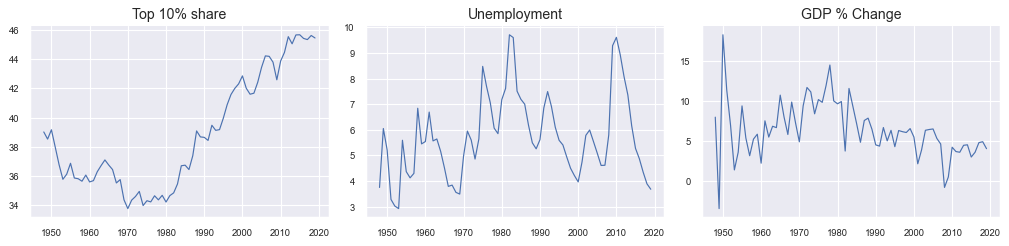

In [83]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=85, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)

plt.tight_layout();

In [84]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=5
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        

,Top 10% share_x,Unemployment_x,GDP % Change_x
Top 10% share_y,1.0000,0.0000,0.002
Unemployment_y,0.0216,1.0000,0.000
GDP % Change_y,0.0000,0.0002,1.000


In [85]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (68, 3)
print(df_test.shape)  # (4, 3)

(68, 3)
(4, 3)


In [86]:
for i in range(len(df.columns)):
  result = adfuller(df[df.columns[i]])

  if result[1] > 0.05 :
    print('{} - Series is not Stationary'.format(df.columns[i]))
  else:
    print('{} - Series is Stationary'.format(df.columns[i]))

Top 10% share - Series is not Stationary
Unemployment - Series is Stationary
GDP % Change - Series is Stationary


In [87]:
df_differenced = df_train.diff().dropna()

In [88]:
for i in range(len(df_differenced.columns)):
  result = adfuller(df_differenced[df_differenced.columns[i]])

  if result[1] > 0.05 :
    print('{} - Series is not Stationary'.format(df_differenced.columns[i]))
  else:
    print('{} - Series is Stationary'.format(df_differenced.columns[i]))

Top 10% share - Series is Stationary
Unemployment - Series is Stationary
GDP % Change - Series is Stationary


In [89]:
model = VAR(df_differenced)

for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  1.0643585473733888
BIC :  1.4624775913781933
FPE :  2.900272664313901
HQIC:  1.2216743037617235 

Lag Order = 2
AIC :  0.5956808182210368
BIC :  1.2981751669565502
FPE :  1.818835202318684
HQIC:  0.8728598736808236 

Lag Order = 3
AIC :  0.4357128533021175
BIC :  1.4476892986269636
FPE :  1.5580826475067504
HQIC:  0.8343814926581086 

Lag Order = 4
AIC :  0.5976187142006408
BIC :  1.9243211638715898
FPE :  1.8508675602992732
HQIC:  1.1194172723827902 

Lag Order = 5
AIC :  0.3883088411732225
BIC :  2.035122558627487
FPE :  1.528251138659492
HQIC:  1.034889454301302 

Lag Order = 6
AIC :  0.2784785744141527
BIC :  2.250934480281017
FPE :  1.408742080307919
HQIC:  1.0515025291979891 

Lag Order = 7
AIC :  0.42735078452778996
BIC :  2.7311298029721005
FPE :  1.7070215140183276
HQIC:  1.3284854066714855 

Lag Order = 8
AIC :  0.46609233880714696
BIC :  3.1070297675008582
FPE :  1.8909668897428338
HQIC:  1.4970073520078562 

Lag Order = 9
AIC :  0.3537638252763151
BIC :

In [90]:
model_fitted = model.fit(6)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 09, Jun, 2021
Time:                     15:48:21
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    2.25093
Nobs:                     61.0000    HQIC:                   1.05150
Log likelihood:          -211.159    FPE:                    1.40874
AIC:                     0.278479    Det(Omega_mle):        0.624527
--------------------------------------------------------------------
Results for equation Top 10% share
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.078762         0.085814            0.918           0.359
L1.Top 10% share         0.100338         0.149021            0.673           0.501
L1.Unemployment         -0.020872       

In [91]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Top 10% share : 2.04
Unemployment : 1.91
GDP % Change : 1.87


In [92]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

6


array([[ 1.29      ,  0.325     ,  3.71904   ],
       [ 0.59      , -0.675     , -0.54379   ],
       [ 1.08      , -0.85833333, -0.08527   ],
       [-0.49      , -0.71666667,  0.8671    ],
       [ 0.61      , -1.2       ,  0.06108   ],
       [ 0.01      , -0.88333333, -1.5255    ]])

In [93]:
index = pd.date_range(start='2016', end='2021',  freq='A')

In [94]:
fc = model_fitted.forecast(y=forecast_input, steps=5)
df_forecast = pd.DataFrame(fc, index=index, columns=df.columns + '_1d')
df_forecast.index = df_forecast.index.year
df_forecast

,Top 10% share_1d,Unemployment_1d,GDP % Change_1d
2016,0.113213,0.154061,0.967669
2017,-0.261774,-0.149416,-1.260947
2018,-0.098422,0.720023,0.360987
2019,0.003036,0.640637,-0.038808
2020,0.060656,0.419999,0.580201


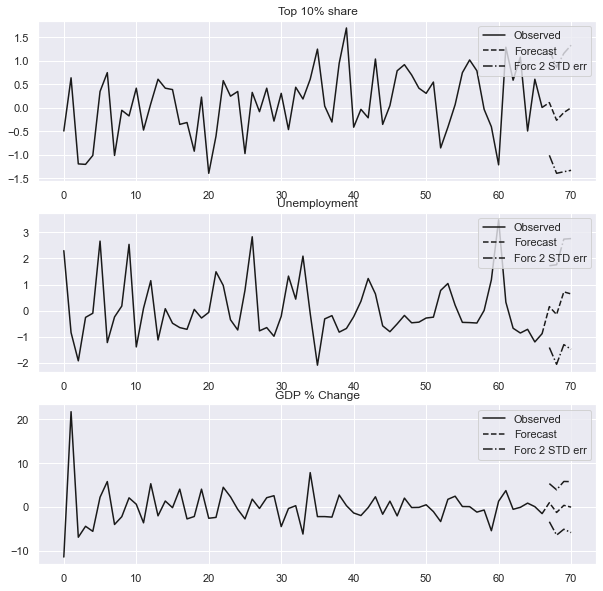

In [95]:
model_fitted.plot_forecast(4);

In [96]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [97]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results[["Top 10% share_forecast", "Unemployment_forecast", "GDP % Change_forecast"]]

,Top 10% share_forecast,Unemployment_forecast,GDP % Change_forecast
2016,45.793213,5.429061,3.930659
2017,45.531439,5.279644,2.669713
2018,45.433017,5.999667,3.030699
2019,45.436053,6.640304,2.991891
2020,45.496710,7.060303,3.572092


In [98]:
df_test.tail(4)

,Top 10% share,Unemployment,GDP % Change
Year,,,
2016,45.43,4.875000,3.55723
2017,45.35,4.350000,4.75702
2018,45.63,3.891667,4.87457
2019,45.46,3.680000,4.00548


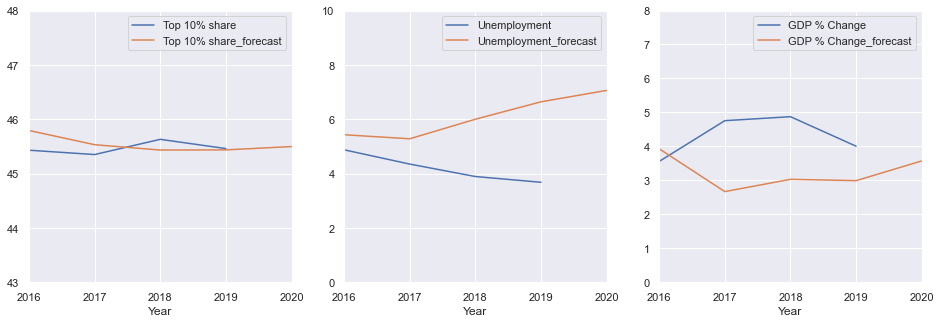

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

df['Top 10% share'][-nobs:].plot(ax=ax1, legend=True).autoscale(axis='x',tight=True)
df_results['Top 10% share_forecast'].plot(ax=ax1, legend=True)
ax1.set_ylim((43,48));

df['Unemployment'][-nobs:].plot(ax=ax2, legend=True).autoscale(axis='x',tight=True)
df_results['Unemployment_forecast'].plot(ax=ax2, legend=True)
ax2.set_ylim((0,10));

df['GDP % Change'][-nobs:].plot(ax=ax3, legend=True).autoscale(axis='x',tight=True)
df_results['GDP % Change_forecast'].plot(ax=ax3, legend=True)
ax3.set_ylim((0,8));

In [100]:
import statsmodels.api as sm
import sklearn.metrics as skm
estVAR = sm.tsa.VAR(df_differenced).fit(6)
skm.r2_score(estVAR.fittedvalues['Top 10% share']+estVAR.resid['Top 10% share'],
  estVAR.fittedvalues['Top 10% share'])

y1 = estVAR.fittedvalues['Top 10% share']+estVAR.resid['Top 10% share']
r_squared = 1 - np.sum(estVAR.resid['Top 10% share'].values**2)/np.sum((y1.values-y1.mean())**2)
adjusted_r_squared_t10p = 1 - (1-r_squared)*(len(y1)-1)/(len(y1)-df_differenced.shape[1]-1)

y2 = estVAR.fittedvalues['Unemployment']+estVAR.resid['Unemployment']
r_squared = 1 - np.sum(estVAR.resid['Unemployment'].values**2)/np.sum((y2.values-y2.mean())**2)
adjusted_r_squared_unemp = 1 - (1-r_squared)*(len(y2)-1)/(len(y2)-df_differenced.shape[1]-1)

y3 = estVAR.fittedvalues['GDP % Change']+estVAR.resid['GDP % Change']
r_squared = 1 - np.sum(estVAR.resid['GDP % Change'].values**2)/np.sum((y3.values-y3.mean())**2)
adjusted_r_squared_gdp = 1 - (1-r_squared)*(len(y3)-1)/(len(y3)-df_differenced.shape[1]-1)

In [101]:
print('Top 10% share Adj. R-squared:', round(adjusted_r_squared_t10p, 2))
print('Unemployment Adj. R-squared:', round(adjusted_r_squared_unemp, 2))
print('GDP per change Adj. R-squared:', round(adjusted_r_squared_gdp,2))

Top 10% share Adj. R-squared: 0.43
Unemployment Adj. R-squared: 0.56
GDP per change Adj. R-squared: 0.52


In [102]:
RMSE1 = rmse(df['Top 10% share'][-nobs:], df_results['Top 10% share_forecast'].head(4))
print(f'Top 10% share VAR(6) RMSE: {RMSE1:.3f}')

RMSE2 = rmse(df['Unemployment'][-nobs:], df_results['Unemployment_forecast'].head(4))
print(f'Unemployment VAR(6) RMSE: {RMSE2:.3f}')

RMSE3 = rmse(df['GDP % Change'][-nobs:], df_results['GDP % Change_forecast'].head(4))
print(f'GDP % Change VAR(6) RMSE: {RMSE3:.3f}')

Top 10% share VAR(6) RMSE: 0.226
Unemployment VAR(6) RMSE: 1.896
GDP % Change VAR(6) RMSE: 1.494


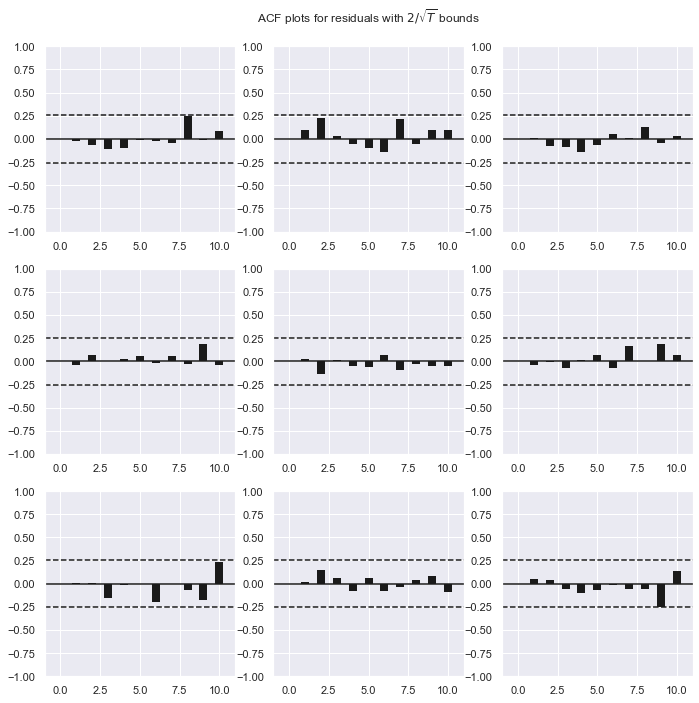

In [103]:
model_fitted.plot_acorr();

In [104]:
irf = model_fitted.irf(5)

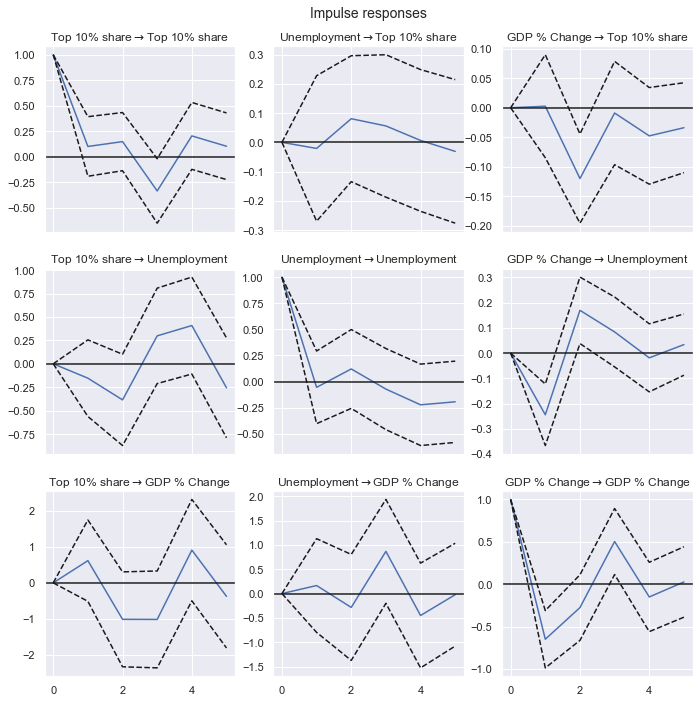

In [105]:
irf.plot(orth=False);

In [106]:
a = model_fitted.test_normality()
a.summary()

Test statistic,Critical value,p-value,df
5.751,12.59,0.452,6


## Let's compare these results to individual AR(p) model

In [65]:
from statsmodels.tsa.ar_model import AR,ARResults

In [66]:
train = df_differenced[['Top 10% share']][0:-nobs]
test = df_differenced[['Top 10% share']][-nobs:]

In [67]:
test

,Top 10% share
Year,
2012,1.08
2013,-0.49
2014,0.61
2015,0.01


In [68]:
model = AR(train)
ARfit = model.fit(maxlag=5, method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 5
Coefficients:
const               0.052255
L1.Top 10% share    0.162868
L2.Top 10% share   -0.014893
L3.Top 10% share   -0.178618
L4.Top 10% share    0.264494
L5.Top 10% share    0.035759
dtype: float64


In [69]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(5) Predictions'

predictions5 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)
predictions5.index = test.index

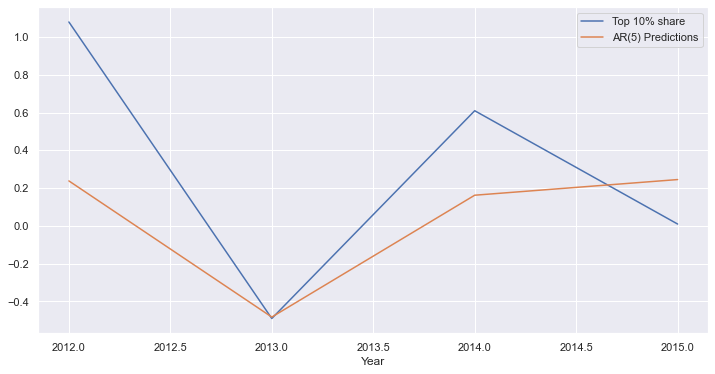

In [71]:
test['Top 10% share'].plot(legend=True)
predictions5.plot(legend=True,figsize=(12,6));

In [72]:
ar_top10_df = pd.DataFrame(ARfit.predict(start=start,end=end,dynamic=False),columns=['Top 10% share'])
ar_top10_df.index = test.index
ar_top10_df

,Top 10% share
Year,
2012,0.238392
2013,-0.482465
2014,0.162671
2015,0.245534


In [73]:
# Add the most recent first difference from the training set to the forecast cumulative sum
ar_top10_df['Top10_1d'] = (df['Top 10% share'].iloc[-nobs-1]-df['Top 10% share'].iloc[-nobs-2]) + ar_top10_df['Top 10% share'].cumsum()

# Now build the forecast values from the first difference set
ar_top10_df['Top10Forecast'] = df['Top 10% share'].iloc[-nobs-1] + ar_top10_df['Top10_1d'].cumsum()

In [74]:
ar_top10_df

,Top 10% share,Top10_1d,Top10Forecast
Year,,,
2012,0.238392,0.248392,45.928392
2013,-0.482465,-0.234073,45.694318
2014,0.162671,-0.071402,45.622916
2015,0.245534,0.174132,45.797048


In [76]:
RMSE_ar = rmse(df['Top 10% share'][-nobs:], ar_top10_df['Top10Forecast'])

print(f'Top 10% share VAR(6) RMSE: {RMSE1:.3f}')
print(f'Top 10% share  AR(5) RMSE: {RMSE_ar:.3f}')

Top 10% share VAR(6) RMSE: 0.226
Top 10% share  AR(5) RMSE: 0.347


# Forecasting Bottom 50% Share

In [107]:
usecols=['Year', 'Bottom 50% share', 'Unemployment', 'GDP % Change']

df = pd.read_excel("final_graduation_project_data.xlsx", parse_dates=["Year"], usecols=usecols)             
df["Year"] = df['Year'].dt.year
df.set_index('Year', inplace=True)

In [108]:
df.head()

,Bottom 50% share,Unemployment,GDP % Change
Year,,,
1948,17.10,3.750000,7.93894
1949,16.72,6.050000,-3.47367
1950,17.32,5.208333,18.22361
1951,18.27,3.283333,11.32476
1952,18.67,3.025000,6.91620


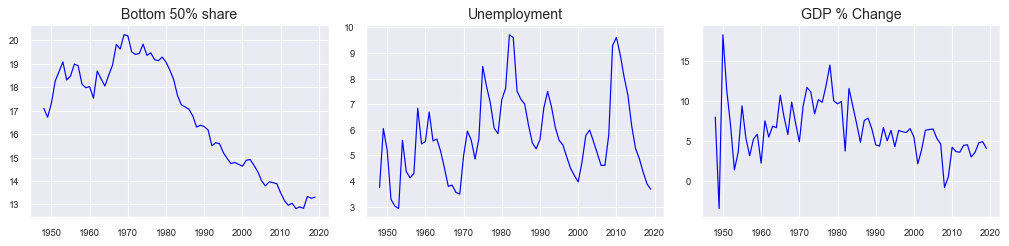

In [110]:
# Plot
fig, axes = plt.subplots(nrows=1, ncols=3, dpi=85, figsize=(12,3))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=8)

plt.tight_layout();

In [111]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=5
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        

,Bottom 50% share_x,Unemployment_x,GDP % Change_x
Bottom 50% share_y,1.000,0.0064,0.0
Unemployment_y,0.019,1.0000,0.0
GDP % Change_y,0.000,0.0002,1.0


In [112]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (68, 3)
print(df_test.shape)  # (4, 3)

(68, 3)
(4, 3)


In [113]:
for i in range(len(df.columns)):
  result = adfuller(df[df.columns[i]])

  if result[1] > 0.05 :
    print('{} - Series is not Stationary'.format(df.columns[i]))
  else:
    print('{} - Series is Stationary'.format(df.columns[i]))

Bottom 50% share - Series is not Stationary
Unemployment - Series is Stationary
GDP % Change - Series is Stationary


In [114]:
df_differenced = df_train.diff().dropna()

In [115]:
for i in range(len(df_differenced.columns)):
  result = adfuller(df_differenced[df_differenced.columns[i]])

  if result[1] > 0.05 :
    print('{} - Series is not Stationary'.format(df_differenced.columns[i]))
  else:
    print('{} - Series is Stationary'.format(df_differenced.columns[i]))

Bottom 50% share - Series is Stationary
Unemployment - Series is Stationary
GDP % Change - Series is Stationary


In [116]:
model = VAR(df_differenced)

for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -0.011827582684563631
BIC :  0.38629146132024095
FPE :  0.9886831475256412
HQIC:  0.1454881737037712 

Lag Order = 2
AIC :  -0.7423422143679234
BIC :  -0.03984786563240994
FPE :  0.47719658977182494
HQIC:  -0.46516315890813653 

Lag Order = 3
AIC :  -0.8837620695401467
BIC :  0.1282143757846994
FPE :  0.41643748294227095
HQIC:  -0.4850934301841556 

Lag Order = 4
AIC :  -0.7726654388899679
BIC :  0.5540370107809811
FPE :  0.4701847048616593
HQIC:  -0.2508668807078185 

Lag Order = 5
AIC :  -1.0629284163846733
BIC :  0.583885301069591
FPE :  0.35803904919812324
HQIC:  -0.4163478032565937 

Lag Order = 6
AIC :  -0.8840629600684002
BIC :  1.0883929457984642
FPE :  0.4405002042566592
HQIC:  -0.11103900528456379 

Lag Order = 7
AIC :  -0.8469043541633905
BIC :  1.45687466428092
FPE :  0.4773501016699789
HQIC:  0.05423026798030506 

Lag Order = 8
AIC :  -1.0080603508200627
BIC :  1.6328770778736486
FPE :  0.43297971073841834
HQIC:  0.022854662380646484 

Lag Order = 9
AI

In [117]:
model_fitted = model.fit(5)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 09, Jun, 2021
Time:                     15:50:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   0.583885
Nobs:                     62.0000    HQIC:                 -0.416348
Log likelihood:          -182.972    FPE:                   0.358039
AIC:                     -1.06293    Det(Omega_mle):        0.179813
--------------------------------------------------------------------
Results for equation Bottom 50% share
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                      -0.061279         0.039965           -1.533           0.125
L1.Bottom 50% share         0.161752         0.139060            1.163           0.245
L1.Unemployment          

In [118]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

Bottom 50% share : 2.03
Unemployment : 2.06
GDP % Change : 2.12


In [119]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

5


array([[-0.33      , -0.675     , -0.54379   ],
       [-0.2       , -0.85833333, -0.08527   ],
       [ 0.09      , -0.71666667,  0.8671    ],
       [-0.23      , -1.2       ,  0.06108   ],
       [ 0.07      , -0.88333333, -1.5255    ]])

In [120]:
index = pd.date_range(start='2016', end='2021',  freq='A')
index

DatetimeIndex(['2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31',
               '2020-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')

In [121]:
fc = model_fitted.forecast(y=forecast_input, steps=5)
df_forecast = pd.DataFrame(fc, index=index, columns=df.columns + '_1d')
df_forecast

,Bottom 50% share_1d,Unemployment_1d,GDP % Change_1d
2016-12-31,-0.115924,0.376571,-0.498461
2017-12-31,0.133859,0.532775,-1.317189
2018-12-31,-0.094896,0.814068,0.477718
2019-12-31,-0.210611,0.243477,0.517822
2020-12-31,-0.083432,0.098911,0.283032


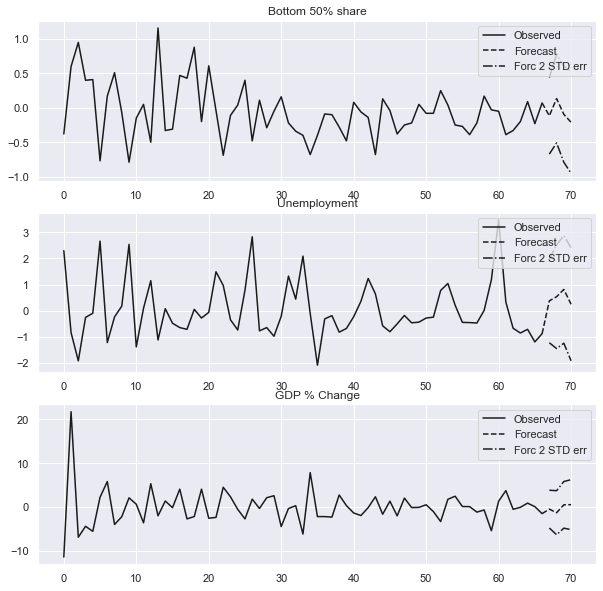

In [122]:
model_fitted.plot_forecast(4);

In [ ]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [123]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results.index = df_results.index.year
df_results[["Bottom 50% share_forecast", "Unemployment_forecast", "GDP % Change_forecast"]]

,Bottom 50% share_forecast,Unemployment_forecast,GDP % Change_forecast
2016,12.774076,5.651571,2.464529
2017,12.907935,6.184346,1.147340
2018,12.813039,6.998413,1.625058
2019,12.602428,7.241891,2.142880
2020,12.518996,7.340801,2.425912


In [ ]:
df.tail()

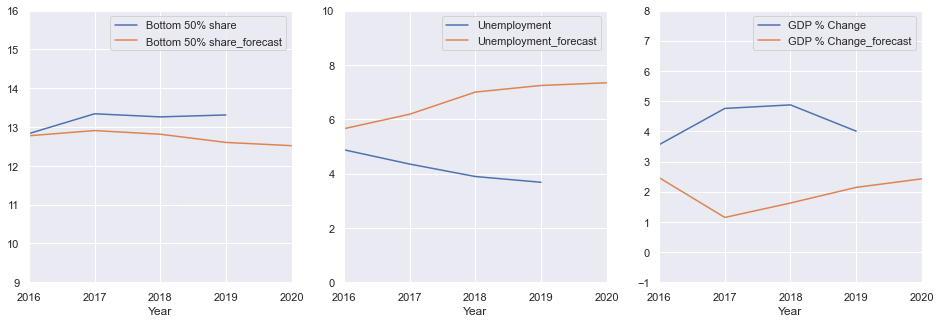

In [124]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

df['Bottom 50% share'][-nobs:].plot(ax=ax1, legend=True).autoscale(axis='x',tight=True)
df_results['Bottom 50% share_forecast'].plot(ax=ax1, legend=True)
ax1.set_ylim((9,16));

df['Unemployment'][-nobs:].plot(ax=ax2, legend=True).autoscale(axis='x',tight=True)
df_results['Unemployment_forecast'].plot(ax=ax2, legend=True)
ax2.set_ylim((0,10));

df['GDP % Change'][-nobs:].plot(ax=ax3, legend=True).autoscale(axis='x',tight=True)
df_results['GDP % Change_forecast'].plot(ax=ax3, legend=True)
ax3.set_ylim((-1,8));

In [125]:
import statsmodels.api as sm
import sklearn.metrics as skm
estVAR = sm.tsa.VAR(df_differenced).fit(5)
skm.r2_score(estVAR.fittedvalues['Bottom 50% share']+estVAR.resid['Bottom 50% share'],
  estVAR.fittedvalues['Bottom 50% share'])

y1 = estVAR.fittedvalues['Bottom 50% share']+estVAR.resid['Bottom 50% share']
r_squared = 1 - np.sum(estVAR.resid['Bottom 50% share'].values**2)/np.sum((y1.values-y1.mean())**2)
adjusted_r_squared_b50p = 1 - (1-r_squared)*(len(y1)-1)/(len(y1)-df_differenced.shape[1]-1)

y2 = estVAR.fittedvalues['Unemployment']+estVAR.resid['Unemployment']
r_squared = 1 - np.sum(estVAR.resid['Unemployment'].values**2)/np.sum((y2.values-y2.mean())**2)
adjusted_r_squared_unemp = 1 - (1-r_squared)*(len(y2)-1)/(len(y2)-df_differenced.shape[1]-1)

y3 = estVAR.fittedvalues['GDP % Change']+estVAR.resid['GDP % Change']
r_squared = 1 - np.sum(estVAR.resid['GDP % Change'].values**2)/np.sum((y3.values-y3.mean())**2)
adjusted_r_squared_gdp = 1 - (1-r_squared)*(len(y3)-1)/(len(y3)-df_differenced.shape[1]-1)

In [ ]:
print('Bottom 50p Adj. R-squared:', round(adjusted_r_squared_b50p, 2))
print('Unemployment Adj. R-squared:', round(adjusted_r_squared_unemp, 2))
print('GDP per change Adj. R-squared:', round(adjusted_r_squared_gdp,2))

In [126]:
RMSE1 = rmse(df['Bottom 50% share'][-nobs:], df_results['Bottom 50% share_forecast'].head(4))
print(f'Bottom 50% share VAR(2) RMSE: {RMSE1:.3f}')

RMSE2 = rmse(df['Unemployment'][-nobs:], df_results['Unemployment_forecast'].head(4))
print(f'Unemployment VAR(2) RMSE: {RMSE2:.3f}')

RMSE3 = rmse(df['GDP % Change'][-nobs:], df_results['GDP % Change_forecast'].head(4))
print(f'GDP % Change VAR(2) RMSE: {RMSE3:.3f}')

Bottom 50% share VAR(2) RMSE: 0.472
Unemployment VAR(2) RMSE: 2.565
GDP % Change VAR(2) RMSE: 2.658


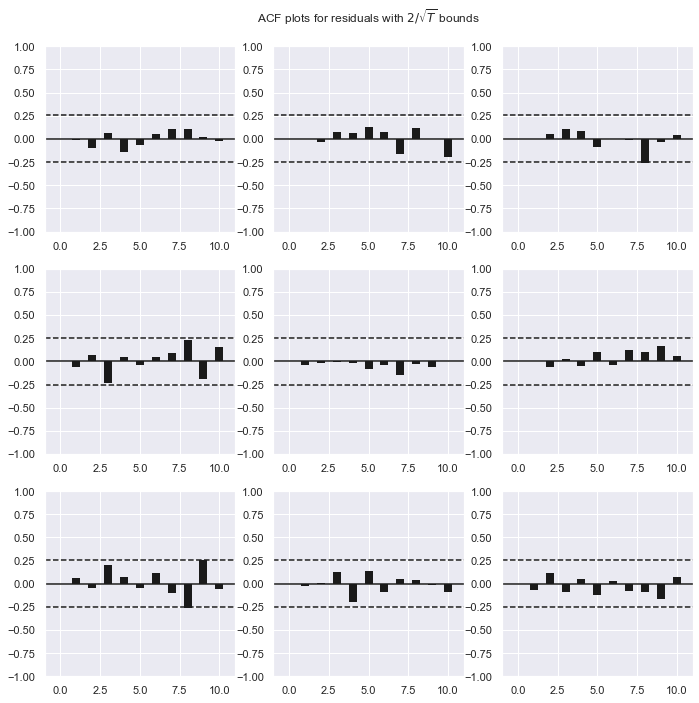

In [127]:
model_fitted.plot_acorr();

In [128]:
irf = model_fitted.irf(5)

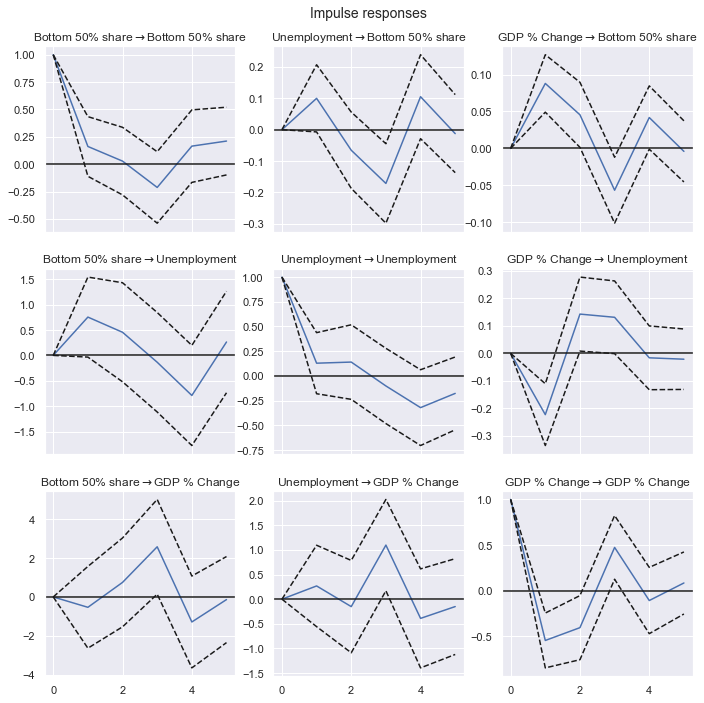

In [129]:
irf.plot(orth=False);

In [131]:
a = model_fitted.test_normality()
a.summary()

Test statistic,Critical value,p-value,df
7.082,12.59,0.313,6


## Let's compare these results to individual AR(p) model

In [132]:
train = df_differenced[['Bottom 50% share']][0:-nobs]
test = df_differenced[['Bottom 50% share']][-nobs:]

In [174]:
model = AR(train)
ARfit = model.fit(maxlag=5, method='mle')
print(f'Lag: {ARfit.k_ar}')
print(f'Coefficients:\n{ARfit.params}')

Lag: 5
Coefficients:
const                 -0.032928
L1.Bottom 50% share    0.082436
L2.Bottom 50% share   -0.035288
L3.Bottom 50% share    0.056499
L4.Bottom 50% share    0.019644
L5.Bottom 50% share    0.233761
dtype: float64


In [175]:
start = len(train)
end = len(train)+len(test)-1
rename = f'AR(5) Predictions'

predictions5 = ARfit.predict(start=start,end=end,dynamic=False).rename(rename)
predictions5.index = test.index

In [177]:
ar_bottom50_df = pd.DataFrame(ARfit.predict(start=start,end=end,dynamic=False),columns=['Bottom 50% share'])
ar_bottom50_df.index = test.index
ar_bottom50_df

,Bottom 50% share
Year,
2012,-0.010044
2013,-0.052140
2014,-0.074865
2015,-0.135476


In [178]:
# Add the most recent first difference from the training set to the forecast cumulative sum
ar_bottom50_df['Bottom50_1d'] = (df['Bottom 50% share'].iloc[-nobs-1]-df['Bottom 50% share'].iloc[-nobs-2]) + ar_bottom50_df['Bottom 50% share'].cumsum()

# Now build the forecast values from the first difference set
ar_bottom50_df['Bottom50Forecast'] = df['Bottom 50% share'].iloc[-nobs-1] + ar_bottom50_df['Bottom50_1d'].cumsum()

In [179]:
ar_bottom50_df

,Bottom 50% share,Bottom50_1d,Bottom50Forecast
Year,,,
2012,-0.010044,0.059956,12.949956
2013,-0.052140,0.007815,12.957771
2014,-0.074865,-0.067050,12.890720
2015,-0.135476,-0.202526,12.688194


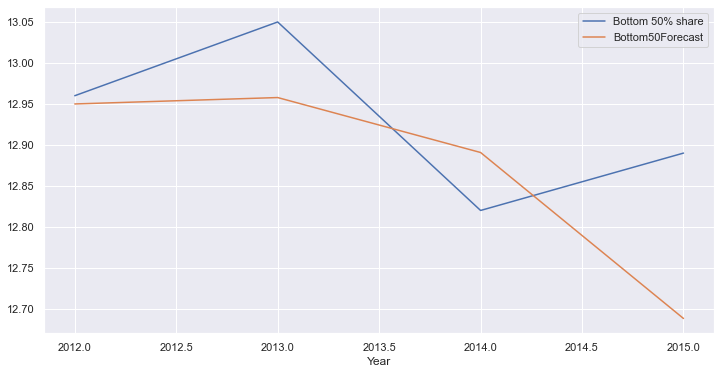

In [186]:
df_train[-nobs:]['Bottom 50% share'].plot(legend=True)
ar_bottom50_df['Bottom50Forecast'].plot(legend=True,figsize=(12,6));

In [181]:
RMSE_ar = rmse(df['Bottom 50% share'][-nobs:], ar_bottom50_df['Bottom50Forecast'])

print(f'Bottom 50% share VAR(5) RMSE: {RMSE1:.3f}')
print(f'Bottom 50% share  AR(5) RMSE: {RMSE_ar:.3f}')

Bottom 50% share VAR(5) RMSE: 0.472
Bottom 50% share  AR(5) RMSE: 0.413
